In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

In [24]:
df = pd.read_csv('./Sample_Superstore.csv', encoding='windows-1252')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.shape

(9994, 21)

In [4]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [5]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [6]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

#### Set up data for modeling

In [26]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [27]:
df = df.resample('W-Mon', on='Order Date').sum().reset_index().sort_values(by='Order Date')

In [28]:
df.set_index('Order Date', inplace=True)
df.sort_index(inplace=True)

In [29]:
# Select only the realgdp, pop, unemp columns.
df = df[['Sales','Quantity','Profit', 'Discount']].copy()
df.head()

,Sales,Quantity,Profit,Discount
Order Date,,,,
2014-01-06,4731.144,43,1302.4975,1.60
2014-01-13,3746.267,67,638.3296,2.85
2014-01-20,3629.202,109,309.6172,4.80
2014-01-27,1595.188,58,183.3509,0.40
2014-02-03,1312.752,30,261.4254,1.65


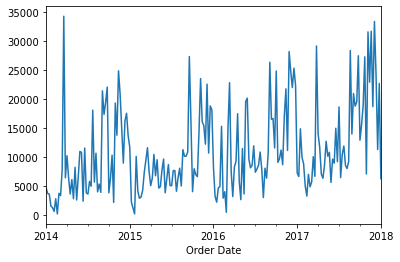

In [31]:
df['Sales'].plot();

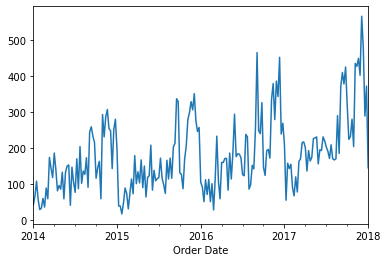

In [32]:
df['Quantity'].plot();

In [33]:
df.shape

(209, 4)

In [34]:
df.dtypes

Sales       float64
Quantity      int64
Profit      float64
Discount    float64
dtype: object

In [37]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    p_without = f'p-value without scientific notation:' "{:.17f}".format(float(dfoutput[1]))
    return dfoutput, p_without

In [38]:
# Run ADF test on the original Real GDP data.
tiffyDIFF = df['Sales'].diff().dropna()
interpret_dftest(adfuller(tiffyDIFF))

(Test Statistic   -7.465777e+00
 p-value           5.209384e-11
 Lag Used          9.000000e+00
 dtype: float64,
 'p-value without scientific notation:0.00000000005209384')

In [44]:
# Run ADF test on the original Real GDP data.
tiffyDIFF = df['Quantity'].dropna()
interpret_dftest(adfuller(tiffyDIFF))

(Test Statistic   -4.389311
 p-value           0.000310
 Lag Used          1.000000
 dtype: float64,
 'p-value without scientific notation:0.00031003237892700')

In [45]:
# Run ADF test on the original Real GDP data.
tiffyDIFF = df['Profit'].dropna()
interpret_dftest(adfuller(tiffyDIFF))

(Test Statistic   -8.047535e+00
 p-value           1.777892e-12
 Lag Used          2.000000e+00
 dtype: float64,
 'p-value without scientific notation:0.00000000000177789')

In [46]:
# Run ADF test on the original Real GDP data.
tiffyDIFF = df['Sales'].dropna()
interpret_dftest(adfuller(tiffyDIFF))

(Test Statistic   -5.970649e+00
 p-value           1.939913e-07
 Lag Used          1.000000e+00
 dtype: float64,
 'p-value without scientific notation:0.00000019399129006')

In [47]:
# Run ADF test on the original Real GDP data.
tiffyDIFF = df['Discount'].dropna()
interpret_dftest(adfuller(tiffyDIFF))

(Test Statistic   -4.780393
 p-value           0.000059
 Lag Used          1.000000
 dtype: float64,
 'p-value without scientific notation:0.00005928278548922')

In [48]:
train, test = train_test_split(df,
                               test_size = 0.2,
                               shuffle=False)

In [49]:
train.head()

,Sales,Quantity,Profit,Discount
Order Date,,,,
2014-01-06,4731.144,43,1302.4975,1.60
2014-01-13,3746.267,67,638.3296,2.85
2014-01-20,3629.202,109,309.6172,4.80
2014-01-27,1595.188,58,183.3509,0.40
2014-02-03,1312.752,30,261.4254,1.65


#### Modeling

In [50]:
model = VAR(train)

In [63]:
ts_model = model.fit(maxlags=5,
                     ic='aic') 

In [64]:
ts_model.k_ar

1

In [65]:
train.tail()

,Sales,Quantity,Profit,Discount
Order Date,,,,
2017-02-13,3300.8130,68,170.5911,3.35
2017-02-20,7054.4654,121,44.3754,7.02
2017-02-27,4892.5180,79,716.7423,3.30
2017-03-06,5714.9280,164,1462.1069,5.50
2017-03-13,10091.7840,171,1386.6163,7.30


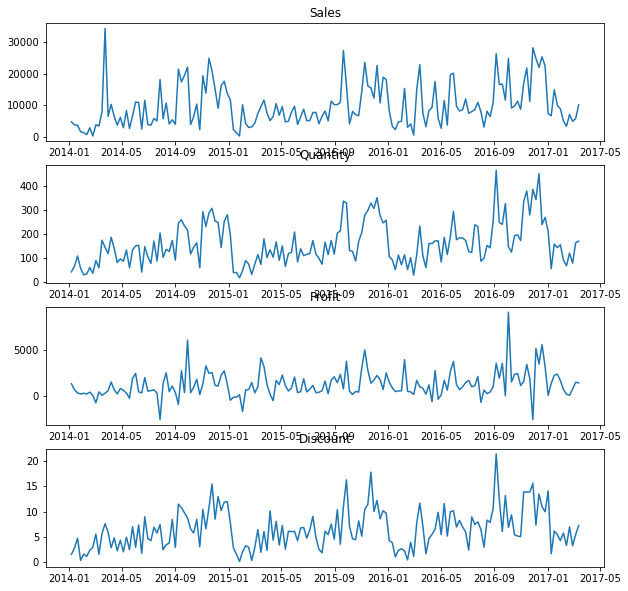

In [66]:
ts_model.plot();

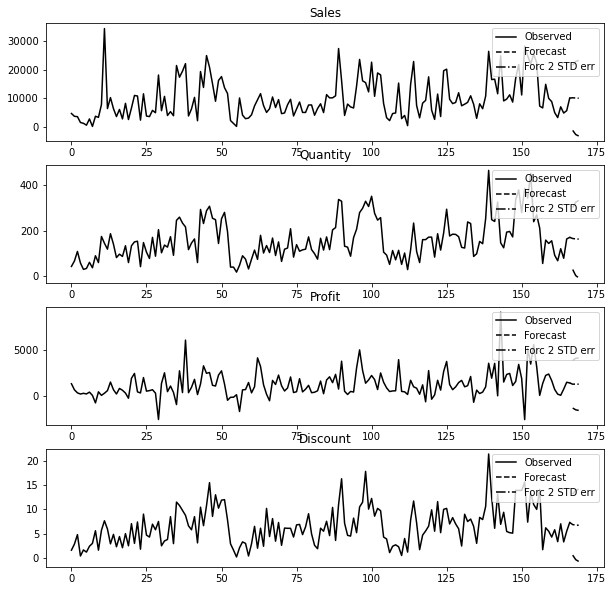

In [67]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);

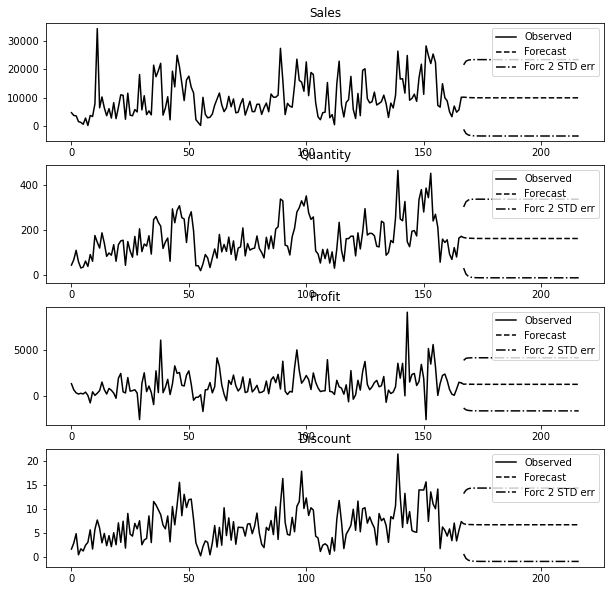

In [68]:
# Plot the forecast looking 50 steps ahead.
ts_model.plot_forecast(50);

In [69]:
# Generate a forecast one step ahead.
ts_model.forecast(train.values, 1)

array([[1.01909841e+04, 1.65986121e+02, 1.24998530e+03, 6.86611106e+00]])

In [70]:
test.shape[0]

42

In [71]:
# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, test.shape[0])

array([[1.01909841e+04, 1.65986121e+02, 1.24998530e+03, 6.86611106e+00],
       [1.01120850e+04, 1.64131990e+02, 1.26415127e+03, 6.75853191e+00],
       [1.00460376e+04, 1.63213646e+02, 1.25219135e+03, 6.72524848e+00],
       [1.00094856e+04, 1.62618891e+02, 1.24613364e+03, 6.70113434e+00],
       [9.98658675e+03, 1.62253602e+02, 1.24245862e+03, 6.68642828e+00],
       [9.97245773e+03, 1.62028397e+02, 1.24016713e+03, 6.67737894e+00],
       [9.96374629e+03, 1.61889433e+02, 1.23875606e+03, 6.67179149e+00],
       [9.95837171e+03, 1.61803711e+02, 1.23788554e+03, 6.66834506e+00],
       [9.95505622e+03, 1.61750830e+02, 1.23734850e+03, 6.66621900e+00],
       [9.95301093e+03, 1.61718208e+02, 1.23701721e+03, 6.66490745e+00],
       [9.95174921e+03, 1.61698084e+02, 1.23681285e+03, 6.66409836e+00],
       [9.95097087e+03, 1.61685669e+02, 1.23668677e+03, 6.66359925e+00],
       [9.95049072e+03, 1.61678011e+02, 1.23660900e+03, 6.66329135e+00],
       [9.95019452e+03, 1.61673287e+02, 1.23656102e

In [72]:
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
forecast = ts_model.forecast(train.values, test.shape[0])

In [74]:
for i in range(test.shape[1]):
    print(f'The test R2 on the {test.columns[i]} data is: {round(r2_score(test.values[:, i], forecast[:, i]), 4)}')
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')
    print()

The test R2 on the Sales data is: -0.4763
The test MSE on the Sales data is: 96869186.3845

The test R2 on the Quantity data is: -0.9466
The test MSE on the Quantity data is: 22464.5574

The test R2 on the Profit data is: -0.1343
The test MSE on the Profit data is: 4193124.6213

The test R2 on the Discount data is: -0.8556
The test MSE on the Discount data is: 40.2781

